In [1]:
import pandas as pd
from dna_features_viewer import GraphicFeature, GraphicRecord
import itertools
from Bio import Phylo
import plotnine as pn

In [2]:
def import_gff(file):
    with open(file, 'r') as openfile:
        out = []
        for line in openfile:
            if line.strip() == "##FASTA" or line[0] == ' ':
                break
            if line[0] == "#":
                continue
            L = line.split('\t')
            gene = {}
            gene["start"] = int(L[3])
            gene["end"] = int(L[4])
            gene["strand"] = 1 if L[6]=="+" else -1
            gene['id'] = L[8].split(';')[0].split('=')[1]
            gene['product'] = line.split(';')[-1].split('=')[1].strip()
            out.append(gene)
    return(out)

def pct_identity(genome1, genome2):
    assert len(genome1) == len(genome2)
    matches = 0
    tot = len(genome1)
    for i in range(tot):
        if genome1[i] == genome2[i]:
            matches += 1
    return(matches/tot)

In [40]:
!cat roary_output/myo/_1619641837/summary_statistics.txt

Core genes	(85% <= strains <= 100%)	70
Soft core genes	(84% <= strains < 85%)	0
Shell genes	(15% <= strains < 84%)	266
Cloud genes	(0% <= strains < 15%)	51
Total genes	(0% <= strains <= 100%)	387


### Import gene presence

In [6]:
myo_presence = pd.read_csv("roary_output/myo/_1619651634/gene_presence_absence.csv")
sipho_presence = pd.read_csv("roary_output/sipho/_1619723868/gene_presence_absence.csv")

sipho_phages = ['CCS2', 'CCS3','P11_phage', 'P13_phage', 'P2_phage', 'P9_phage', 'SDS1', 'SDS2','Toy']
myo_phages = ['Ben', 'Bill', 'Bob', 'Bop','CCS1', 'Car', 'Carl', 'TEX', 'V12']
koch = ["Bob","Car","Carl"]
shiek = ["Ben","Bill","Bop","CCS1","TEX","V12"]
myo_presence["koch_seqs"] = myo_presence[koch].apply(axis=1, func= lambda row: sum([x==x for x in row]))
myo_presence["shiek_seqs"] = myo_presence[shiek].apply(axis=1, func= lambda row: sum([x==x for x in row]))
myo_presence.head()

,Gene,Non-unique Gene name,Annotation,No. isolates,No. sequences,Avg sequences per isolate,Genome Fragment,Order within Fragment,Accessory Fragment,Accessory Order with Fragment,...,Bill,Bob,Bop,CCS1,Car,Carl,TEX,V12,koch_seqs,shiek_seqs
0,group_1,NaN,Virion protein 4,9,9,1,1,96,NaN,NaN,...,BMFEEFKN_00167,MLFNPOEP_00164,LPIHEJCG_00183,ILFNCBME_00174,HGEFLFKG_00166,AHGFFIMK_00156,OFPAFGCJ_00165,GLLPMOLK_00187,3,6
1,group_116,NaN,hypothetical protein,9,9,1,1,60,NaN,NaN,...,BMFEEFKN_00138,MLFNPOEP_00134,LPIHEJCG_00154,ILFNCBME_00142,HGEFLFKG_00136,AHGFFIMK_00124,OFPAFGCJ_00137,GLLPMOLK_00158,3,6
2,group_127,NaN,hypothetical protein,9,9,1,1,341,NaN,NaN,...,BMFEEFKN_00127,MLFNPOEP_00123,LPIHEJCG_00143,ILFNCBME_00129,HGEFLFKG_00125,AHGFFIMK_00113,OFPAFGCJ_00126,GLLPMOLK_00147,3,6
3,group_13,NaN,hypothetical protein,9,9,1,1,337,NaN,NaN,...,BMFEEFKN_00131,MLFNPOEP_00127,LPIHEJCG_00147,ILFNCBME_00133,HGEFLFKG_00129,AHGFFIMK_00117,OFPAFGCJ_00130,GLLPMOLK_00151,3,6
4,group_134,NaN,hypothetical protein,9,9,1,1,111,NaN,NaN,...,BMFEEFKN_00180,MLFNPOEP_00177,LPIHEJCG_00197,ILFNCBME_00189,HGEFLFKG_00179,AHGFFIMK_00169,OFPAFGCJ_00180,GLLPMOLK_00200,3,6


In [7]:
sipho_core = {}
sipho_acc = {}
sipho_uni = {}
for phage in sipho_phages:
    a = sipho_presence.loc[sipho_presence[phage].notna()]
    cores = len(a.query('`No. isolates` == 9'))
    accs = len(a.query('`No. isolates` != 9'))
    uni = len(a.query('`No. isolates` == 1'))
    sipho_core[phage] = cores
    sipho_acc[phage] = accs
    sipho_uni[phage] = uni



In [681]:
np.std(list(sipho_acc.values()))

2.096440251568134

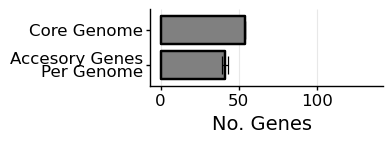

<ggplot: (8767745918418)>

In [135]:
dat = pd.DataFrame([["Core Genome",54,54,54],["Accesory Genes\nPer Genome",41,43,39]], index=[1,2], columns = ["lab","ct","errp","errn"])
pn.options.figure_size = (3,1)

p = (pn.ggplot(data = dat)  +
    pn.geom_bar( pn.aes(x="lab", y="ct"), stat="identity", fill="grey", color="black", size=1, width=.8) +
     pn.geom_errorbar(pn.aes( x="lab",ymax = "errp", ymin="errn")) +
     pn.theme_classic() +
     pn.scale_y_continuous(limits=[0,135]) +
     pn.labs(y="No. Genes", x='') +
     pn.coord_flip() +
     pn.theme(text = pn.element_text(color="black"),
             panel_grid_major_x = pn.element_line(color="lightgrey", alpha=.5),
             axis_title = pn.element_text(size=14),
             axis_text = pn.element_text(size=12),)
    )
p

In [8]:
myo_core = {}
myo_acc = {}
myo_uni = {}
for phage in myo_phages:
    a = myo_presence.loc[myo_presence[phage].notna()]
    cores = len(a.query('`No. isolates` == 9'))
    accs = len(a.query('`No. isolates` != 9'))
    uni = len(a.query('`No. isolates` == 1'))
    myo_core[phage] = cores
    myo_acc[phage] = accs
    myo_uni[phage] = uni



In [695]:
myo_core

{'Ben': 66,
 'Bill': 66,
 'Bob': 66,
 'Bop': 66,
 'CCS1': 66,
 'Car': 66,
 'Carl': 66,
 'TEX': 66,
 'V12': 66}

In [688]:
np.std(list(myo_acc.values()))

9.386094258641279

In [694]:
np.array(list(myo_acc.values())).mean()

124.11111111111111

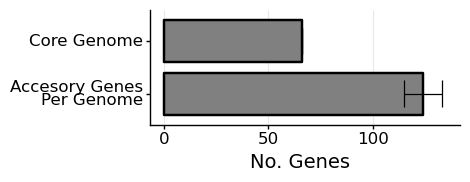

<ggplot: (8767745918715)>

In [134]:
dat = pd.DataFrame([["Core Genome",66,66,66],["Accesory Genes\nPer Genome",124,133,115]], index=[1,2], columns = ["lab","ct","errp","errn"])
pn.options.figure_size = (4,1.5)

p = (pn.ggplot(data = dat)  +
    pn.geom_bar( pn.aes(x="lab", y="ct"), stat="identity", fill="grey", color="black", size=1, width=.8) +
     pn.geom_errorbar(pn.aes( x="lab",ymax = "errp", ymin="errn")) +
     pn.theme_classic() +
     pn.scale_y_continuous(limits=[0,135]) +
     pn.labs(y="No. Genes", x='') +
     pn.coord_flip() +
     pn.theme(text = pn.element_text(color="black"),
             panel_grid_major_x = pn.element_line(color="lightgrey", alpha=.5),
             axis_title = pn.element_text(size=14),
             axis_text = pn.element_text(size=12),)
    )
p

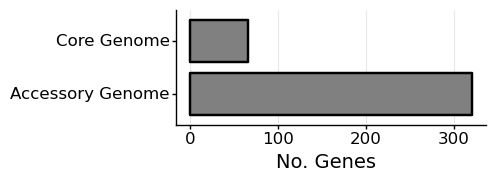

<ggplot: (8767745991266)>

In [131]:
dat = pd.DataFrame([["Core Genome",66],["Accessory Genome",321]], index=[1,2], columns = ["lab","ct"])
pn.options.figure_size = (4,1.5)

p = (pn.ggplot(data = dat)  +
    pn.geom_bar( pn.aes(x="lab", y="ct"), stat="identity", fill="grey", color="black", size=1, width=.8) +
     pn.theme_classic() +
     pn.labs(y="No. Genes", x='') +
     pn.coord_flip() +
     pn.theme(text = pn.element_text(color="black"),
             panel_grid_major_x = pn.element_line(color="lightgrey", alpha=.5),
             axis_title = pn.element_text(size=14),
             axis_text = pn.element_text(size=12),)
    )
p

### Import GFFs

In [4]:
gffs = {}

gff_files = !ls ../comarative_genomics/gffs/sipho/
for file in gff_files:
    name=file.split('.')[0]
    gff = import_gff("../comarative_genomics/gffs2/sipho/" + file)
    gffs[name] = gff
    
gff_files = !ls ../comarative_genomics/gffs/myo/
for file in gff_files:
    name=file.split('.')[0]
    gff = import_gff("../comarative_genomics/gffs/myo/" + file)
    gffs[name] = gff

In [9]:
sds1_gene_counts = {}
for gene in gffs["SDS1"]:
    gene_id = gene["id"]
    tmp = sipho_presence.query('SDS1 == @gene_id')
    if len(tmp)==0:
        sds1_gene_counts[gene_id] = 0
        continue
    ct=0
    for phage in sipho_phages:
        if pd.notna(tmp[phage].iloc[0]):
            ct +=1
    sds1_gene_counts[gene_id] = ct

In [74]:
import matplotlib.pyplot as plt
import matplotlib

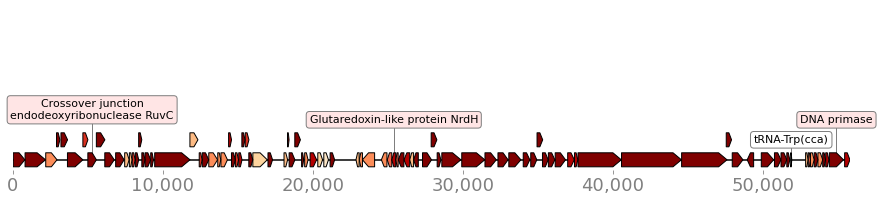

In [102]:

features = []
colors = {i:x for i,x in zip(range(10),["white",'#fff7ec','#fee8c8','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#b30000','#7f0000'])}
for gene in gffs["SDS1"]:
    name = "" if gene["product"] == "hypothetical protein" else gene["product"]
    if name:
        feature = GraphicFeature(start=gene["start"], end=gene["end"], strand=gene["strand"], color=colors[sds1_gene_counts[gene["id"]]], label=name)
    else:
        feature = GraphicFeature(start=gene["start"], end=gene["end"], strand=gene["strand"], color=colors[sds1_gene_counts[gene["id"]]])
    features.append(feature)

    
record = GraphicRecord(sequence_length=gffs["SDS1"][-1]["end"], features=features, ticks_resolution=10000)
fig,ax =  plt.subplots(1, figsize=(15,3))
a = record.plot(figure_width=15,ax = ax)


ax.tick_params(labelsize=18)
plt.savefig("figc.png")

In [252]:
gffs.keys()

dict_keys(['CCS2', 'CCS3', 'CCS4', 'P11_phage', 'P13_phage', 'P2_phage', 'P9_phage', 'SDS1', 'SDS2', 'Toy', 'Ben', 'Bill', 'Bob', 'Bop', 'CCS1', 'Car', 'Carl', 'TEX', 'V12'])

In [96]:
v12_gene_counts = {}
for gene in gffs["V12"]:
    gene_id = gene["id"]
    tmp = myo_presence.query('V12 == @gene_id')
    if len(tmp)==0:
        v12_gene_counts[gene_id] = 0
        continue
    ct=0
    for phage in myo_phages:
        if pd.notna(tmp[phage].iloc[0]):
            ct +=1
    v12_gene_counts[gene_id] = ct

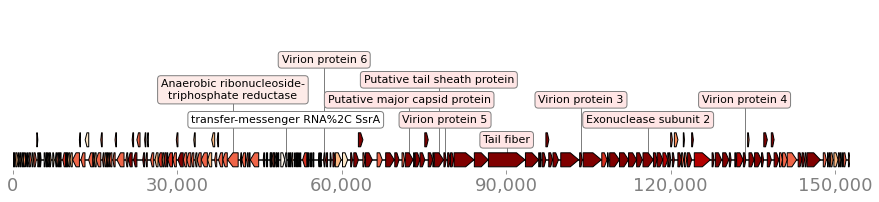

In [101]:

features = []
colors = {i:x for i,x in zip(range(10),["white",'#fff7ec','#fee8c8','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#b30000','#7f0000'])}
for gene in gffs["V12"]:
    name = "" if gene["product"] == "hypothetical protein" else gene["product"]
    name = "" if "tRNA" in name else name 
    name = "Tail fiber" if gene["id"] == "GLLPMOLK_00148" else name
    if name:
        feature = GraphicFeature(start=gene["start"], end=gene["end"], strand=gene["strand"], color=colors[v12_gene_counts[gene["id"]]], label=name)
    else:
        feature = GraphicFeature(start=gene["start"], end=gene["end"], strand=gene["strand"], color=colors[v12_gene_counts[gene["id"]]])
    features.append(feature)

record = GraphicRecord(sequence_length=gffs["V12"][-1]["end"], features=features , ticks_resolution=30000)
fig,ax =  plt.subplots(1, figsize=(15,3))
a = record.plot(figure_width=15,ax = ax)


ax.tick_params(labelsize=18)
plt.savefig("figf.png")

In [638]:
import matplotlib

In [91]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",'#fff7ec','#fee8c8','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#b30000','#7f0000'])

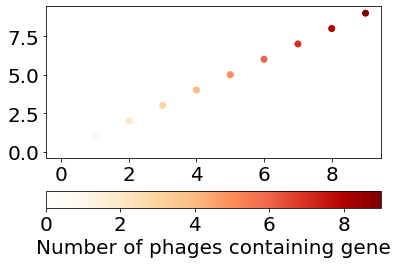

In [94]:
a = plt.scatter(range(10),range(10),c=range(10), cmap=cmap)
plt.colorbar(orientation='horizontal', label="Number of phages containing gene")
plt.rcParams.update({'font.size': 18})
plt.show()

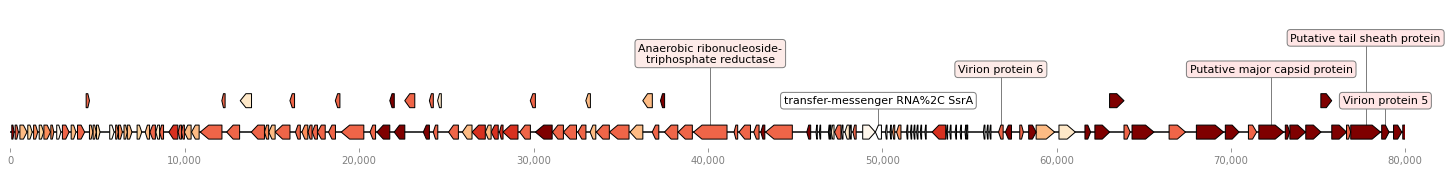

In [653]:

features1 = []
features2 = []
colors = {i:x for i,x in zip(range(10),["white",'#fff7ec','#fee8c8','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#b30000','#7f0000'])}
for gene in gffs["V12"]:
    name = "" if gene["product"] == "hypothetical protein" else gene["product"]
    name = "" if "tRNA" in name else name 
    name = "Tail fiber" if gene["id"] == "GLLPMOLK_00148" else name
    if name:
        feature = GraphicFeature(start=gene["start"], end=gene["end"], strand=gene["strand"], color=colors[v12_gene_counts[gene["id"]]], label=name)
    else:
        feature = GraphicFeature(start=gene["start"], end=gene["end"], strand=gene["strand"], color=colors[v12_gene_counts[gene["id"]]])
    if gene["start"] < 80000:
        features1.append(feature)
    else:
        features2.append(feature)

record = GraphicRecord(sequence_length=80000, features=features1)
a = record.plot(figure_width=25)

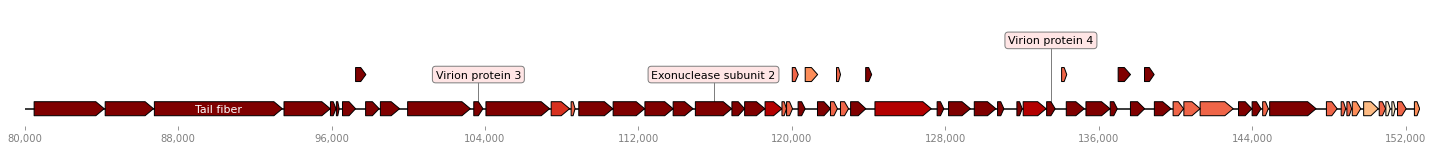

In [654]:
record = GraphicRecord(sequence_length=gffs["V12"][-1]["end"] - 80000, features=features2, first_index=80000,)
b = record.plot(figure_width=25)

In [271]:
import matplotlib.pyplot as plt

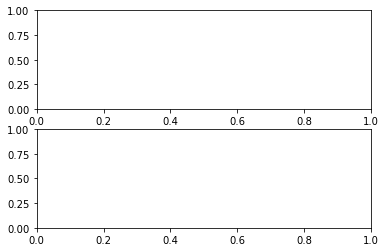

In [288]:
fig,axs =  plt.subplots(2)
axs[0] = a[1]
axs[1] = b

In [473]:
!ls roary_output/sipho/

_1619723868


In [474]:
sipho_alignment = "roary_output/sipho/_1619723868/core_gene_alignment.aln"
with open(sipho_alignment,'r') as openfile:
    sipho_genomes = {}
    seq = ''
    for line in openfile:
        if line[0] == ">":
            if seq:
                sipho_genomes[genome] = seq
            genome = line[1:].strip()
            seq = ''
        else:
            seq += line.strip()
        
all_genomes = list(sipho_genomes.keys())
all_combos = list(itertools.combinations(all_genomes, 2))

sipho_identity_out = []
for genome1, genome2 in all_combos:
    pct = pct_identity(sipho_genomes[genome1], sipho_genomes[genome2])
    sipho_identity_out.append([genome1, genome2, pct])
sipho_identity_df = pd.DataFrame(sipho_identity_out, columns=["genome1","genome2","core_identity"])    

In [475]:
!ls roary_output/myo/

_1619651634


In [484]:
myo_alignment = "roary_output/myo/_1619651634/core_gene_alignment.aln"
with open(myo_alignment,'r') as openfile:
    myo_genomes = {}
    seq = ''
    for line in openfile:
        if line[0] == ">":
            if seq:
                myo_genomes[genome] = seq
            genome = line[1:].strip()
            seq = ''
        else:
            seq += line.strip()
        myo_genomes[genome] = seq
        
all_genomes = list(myo_genomes.keys())
all_combos = list(itertools.combinations(all_genomes, 2))

myo_identity_out = []
for genome1, genome2 in all_combos:
    pct = pct_identity(myo_genomes[genome1], myo_genomes[genome2])
    myo_identity_out.append([genome1, genome2, pct])
myo_identity_df = pd.DataFrame(myo_identity_out, columns=["genome1","genome2","core_identity"])    

In [502]:
tmp = pd.DataFrame(index=myo_phages, columns=myo_phages)
for x in myo_identity_out:
    tmp.loc[x[0],x[1]] = x[2]
    tmp.loc[x[1],x[0]] = x[2]

In [497]:
tmp.dtype = "float"

,Ben,Bill,Bob,Bop,CCS1,Car,Carl,TEX,V12
Ben,0,0.947252,0.599502,0.988997,0.878769,0.599884,0.569918,0.909338,0.957318
Bill,0.947252,0,0.606427,0.946783,0.876723,0.606772,0.576757,0.883993,0.914095
Bob,0.599502,0.606427,0,0.599219,0.595941,0.969344,0.942138,0.572974,0.611762
Bop,0.988997,0.946783,0.599219,0,0.879126,0.599551,0.56961,0.909955,0.955014
CCS1,0.878769,0.876723,0.595941,0.879126,0,0.596286,0.566653,0.921069,0.866275
Car,0.599884,0.606772,0.969344,0.599551,0.596286,0,0.941276,0.57375,0.604579
Carl,0.569918,0.576757,0.942138,0.56961,0.566653,0.941276,0,0.543809,0.582289
TEX,0.909338,0.883993,0.572974,0.909955,0.921069,0.57375,0.543809,0,0.885792
V12,0.957318,0.914095,0.611762,0.955014,0.866275,0.604579,0.582289,0.885792,0


In [541]:
sipho_order = ["CCS2","PG11","SDS2","CCS3","toy","PG2","SDS1","PG9","PG13"]
myo_order = ["Ben","Bop","Bill","V12","Bob","Car","Carl","CCS1","TEX"]
tmp = tmp.loc[myo_order,myo_order]

,Ben,Bop,Bill,V12,Bob,Car,Carl,CCS1,TEX
Ben,0.000000,0.988997,0.947252,0.957318,0.599502,0.599884,0.569918,0.878769,0.909338
Bop,0.988997,0.000000,0.946783,0.955014,0.599219,0.599551,0.569610,0.879126,0.909955
Bill,0.947252,0.946783,0.000000,0.914095,0.606427,0.606772,0.576757,0.876723,0.883993
V12,0.957318,0.955014,0.914095,0.000000,0.611762,0.604579,0.582289,0.866275,0.885792
Bob,0.599502,0.599219,0.606427,0.611762,0.000000,0.969344,0.942138,0.595941,0.572974
Car,0.599884,0.599551,0.606772,0.604579,0.969344,0.000000,0.941276,0.596286,0.573750
Carl,0.569918,0.569610,0.576757,0.582289,0.942138,0.941276,0.000000,0.566653,0.543809
CCS1,0.878769,0.879126,0.876723,0.866275,0.595941,0.596286,0.566653,0.000000,0.921069
TEX,0.909338,0.909955,0.883993,0.885792,0.572974,0.573750,0.543809,0.921069,0.000000


In [566]:
tmp = pd.DataFrame(index=myo_phages, columns=myo_phages)
for x in myo_identity_out:
    tmp.loc[x[0],x[1]] = x[2]
    tmp.loc[x[1],x[0]] = x[2]
tmp = tmp.fillna(0)
myo_order = ["Ben","Bop","Bill","V12","Bob","Car","Carl","CCS1","TEX"]
tmp = tmp.loc[myo_order,myo_order]
tmp

,Ben,Bop,Bill,V12,Bob,Car,Carl,CCS1,TEX
Ben,0.000000,0.988997,0.947252,0.957318,0.599502,0.599884,0.569918,0.878769,0.909338
Bop,0.988997,0.000000,0.946783,0.955014,0.599219,0.599551,0.569610,0.879126,0.909955
Bill,0.947252,0.946783,0.000000,0.914095,0.606427,0.606772,0.576757,0.876723,0.883993
V12,0.957318,0.955014,0.914095,0.000000,0.611762,0.604579,0.582289,0.866275,0.885792
Bob,0.599502,0.599219,0.606427,0.611762,0.000000,0.969344,0.942138,0.595941,0.572974
Car,0.599884,0.599551,0.606772,0.604579,0.969344,0.000000,0.941276,0.596286,0.573750
Carl,0.569918,0.569610,0.576757,0.582289,0.942138,0.941276,0.000000,0.566653,0.543809
CCS1,0.878769,0.879126,0.876723,0.866275,0.595941,0.596286,0.566653,0.000000,0.921069
TEX,0.909338,0.909955,0.883993,0.885792,0.572974,0.573750,0.543809,0.921069,0.000000


[Text(0, 0.5, 'Bop'),
 Text(0, 1.5, 'Bill'),
 Text(0, 2.5, 'V12'),
 Text(0, 3.5, 'Bob'),
 Text(0, 4.5, 'Car'),
 Text(0, 5.5, 'Carl'),
 Text(0, 6.5, 'CCS1'),
 Text(0, 7.5, 'TEX')]

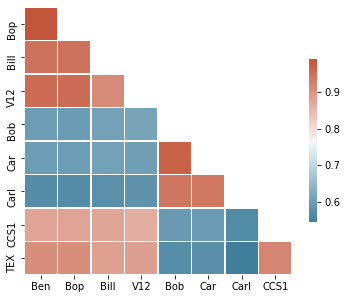

In [568]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

tmp = pd.DataFrame(index=myo_phages, columns=myo_phages)
for x in myo_identity_out:
    tmp.loc[x[0],x[1]] = x[2]
    tmp.loc[x[1],x[0]] = x[2]
tmp = tmp.fillna(0)

df = plot_dat.pivot(index="genome1", columns="genome2", values = "core_identity").transpose()
sipho_order = ["CCS2","PG11","SDS2","CCS3","toy","PG2","SDS1","PG9","PG13"]
myo_order = ["Ben","Bop","Bill","V12","Bob","Car","Carl","CCS1","TEX"]
tmp = tmp.loc[myo_order,myo_order]
tmp = tmp.iloc[1:,:8]
#mask[0,0] = False
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
dat = np.array(tmp)
mask =  np.invert(np.tril(np.ones_like(dat, dtype=bool)))

# Draw the heatmap with the mask and correct aspect ratio

a = sns.heatmap(dat , mask=mask, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
ax.set_xticklabels(myo_order[:8])
ax.set_yticklabels(myo_order[1:])

In [534]:
tmp

,Ben,Bill,Bob,Bop,CCS1,Car,Carl,TEX,V12
Ben,0.000000,0.947252,0.599502,0.988997,0.878769,0.599884,0.569918,0.909338,0.957318
Bill,0.947252,0.000000,0.606427,0.946783,0.876723,0.606772,0.576757,0.883993,0.914095
Bob,0.599502,0.606427,0.000000,0.599219,0.595941,0.969344,0.942138,0.572974,0.611762
Bop,0.988997,0.946783,0.599219,0.000000,0.879126,0.599551,0.569610,0.909955,0.955014
CCS1,0.878769,0.876723,0.595941,0.879126,0.000000,0.596286,0.566653,0.921069,0.866275
Car,0.599884,0.606772,0.969344,0.599551,0.596286,0.000000,0.941276,0.573750,0.604579
Carl,0.569918,0.576757,0.942138,0.569610,0.566653,0.941276,0.000000,0.543809,0.582289
TEX,0.909338,0.883993,0.572974,0.909955,0.921069,0.573750,0.543809,0.000000,0.885792
V12,0.957318,0.914095,0.611762,0.955014,0.866275,0.604579,0.582289,0.885792,0.000000


In [531]:
mask

array([[False,  True,  True,  True,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True,  True,  True],
       [False, False, False, False,  True,  True,  True,  True,  True],
       [False, False, False, False, False,  True,  True,  True,  True],
       [False, False, False, False, False, False,  True,  True,  True],
       [False, False, False, False, False, False, False,  True,  True],
       [False, False, False, False, False, False, False, False,  True],
       [False, False, False, False, False, False, False, False, False]])

/mnt/c/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


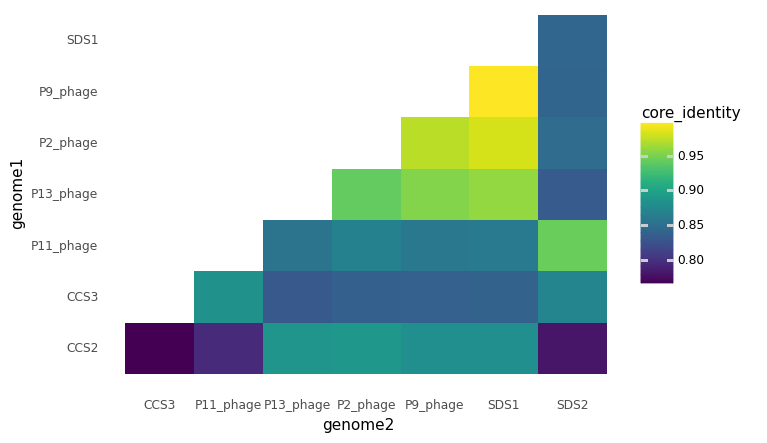

<ggplot: (8771875470496)>

In [309]:
plot_dat = identity_df.query('genome1 != "CCS4" and genome2 != "CCS4"').copy()
plot_dat["genome1"] = pd.Categorical(plot_dat.genome1, categories = sipho_phages)
plot_dat["genome2"] = pd.Categorical(plot_dat.genome2, categories = sipho_phages)


p = (pn.ggplot(data = plot_dat) +
    pn.geom_tile(pn.aes(x="genome1", y="genome2", fill="core_identity")) +
     pn.theme_minimal() +
     pn.coord_flip() +
     pn.theme(
     panel_grid = pn.element_blank()
     )
    )
p

In [103]:
from Bio import Phylo

/tmp/ipykernel_3406/3887335313.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


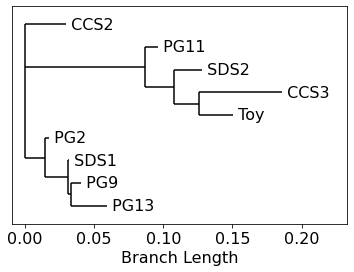

In [120]:
tree = Phylo.read("sipho_tree.newick", "newick")
fig, ax = plt.subplots(1, figsize=(6,4))

matplotlib.rcParams.update({'font.size': 16})
a = Phylo.draw(tree, axes = ax, show_confidence=False, do_show=False)
ax.set_xlabel("Branch Length")
ax.set_ylabel("")
ax.set_yticks([])
fig.show()


[]

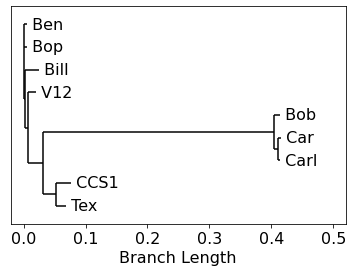

In [125]:
tree = Phylo.read("myo_tree.newick", "newick")
fig, ax = plt.subplots(1, figsize=(6,4))
matplotlib.rcParams.update({'font.size': 16})
a = Phylo.draw(tree, axes = ax, show_confidence=False, do_show=False)
ax.set_xlabel("Branch Length")
ax.set_ylabel("")
ax.set_yticks([])
